In [4]:
import time
import os
import numba
import math
from coffea.nanoevents import BaseSchema

import awkward as ak
import numpy as np
from coffea import processor, hist

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

import mplhep
import matplotlib.pyplot as plt
plt.style.use(mplhep.style.CMS)

# To import bot
import sys

sys.path.insert(1, '/afs/cern.ch/work/m/mabarros/public/CMSSW_10_6_12/src/OniaOpenCharmRun2ULAna/bot')

import bot_config as bot

In [5]:
muon_cols = ['Muon_charge', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_eta', 'Muon_isGlobal', 'Muon_mass',
             'Muon_phi', 'Muon_pt', 'Muon_ptErr', 'Muon_softId', 'Muon_vtxIdx', 'Muon_vtxFlag', 'Muon_simIdx']

dimu_cols = ['Dimu_pt', 'Dimu_eta', 'Dimu_phi', 'Dimu_rap', 'Dimu_mass', 'Dimu_charge', 'Dimu_vtxIdx', 'Dimu_chi2', 'Dimu_dl',
             'Dimu_dlErr', 'Dimu_dlSig', 'Dimu_cosphi', 'Dimu_x', 'Dimu_y', 'Dimu_z', 'Dimu_t1muIdx', 'Dimu_t2muIdx',]

d0_cols = ['D0_pt', 'D0_eta', 'D0_phi', 'D0_rap', 'D0_mass12', 'D0_mass21', 'D0_vtxIdx', 'D0_chi2', 'D0_dl', 'D0_dlErr', 'D0_dlSig',
           'D0_cosphi', 'D0_x', 'D0_y', 'D0_z', 'D0_hasMuon',
           'D0_t1pt', 'D0_t1eta', 'D0_t1phi', 'D0_t1chindof', 'D0_t1nValid', 'D0_t1nPix', 'D0_t1dxy', 'D0_t1dz', 'D0_t1chg', 
           'D0_t2pt', 'D0_t2eta', 'D0_t2phi', 'D0_t2chindof', 'D0_t2nValid', 'D0_t2nPix', 'D0_t2dxy', 'D0_t2dz', 'D0_t2chg',]

dstar_cols = ['Dstar_pt', 'Dstar_eta', 'Dstar_phi', 'Dstar_rap', 'Dstar_deltam', 'Dstar_deltamr', 'Dstar_vtxIdx', 'Dstar_hasMuon',
              'Dstar_D0pt', 'Dstar_D0eta', 'Dstar_D0phi', 'Dstar_D0mass', 'Dstar_D0chi2', 'Dstar_D0dl', 'Dstar_D0dlErr',
              'Dstar_D0dlSig', 'Dstar_D0cosphi', 'Dstar_D0x', 'Dstar_D0y', 'Dstar_D0z',
              'Dstar_Kpt', 'Dstar_Keta', 'Dstar_Kphi', 'Dstar_KvtxIdx', 'Dstar_Kchindof', 'Dstar_KnValid', 'Dstar_KnPix', 'Dstar_Kdxy',
              'Dstar_Kdz', 'Dstar_Kchg', 'Dstar_pipt', 'Dstar_pieta', 'Dstar_piphi', 'Dstar_pivtxIdx', 'Dstar_pichindof', 'Dstar_pinValid',
              'Dstar_pinPix', 'Dstar_pidxy', 'Dstar_pidz', 'Dstar_pichg', 'Dstar_pispt', 'Dstar_piseta', 'Dstar_pisphi', 'Dstar_pisvtxIdx',
              'Dstar_pischindof', 'Dstar_pisnValid', 'Dstar_pisnPix',
              'Dstar_pisdxy', 'Dstar_pisdz', 'Dstar_simIdx', 'Dstar_D0simIdx',
              'Dstar_pisisHighPurity', 'Dstar_piisHighPurity', 'Dstar_KisHighPurity']

gen_part_cols = ['GenPart_eta', 'GenPart_genPartIdxMother', 'GenPart_mass', 'GenPart_pdgId', "GenPart_phi", "GenPart_pt", 'GenPart_status',
                'GenPart_Id', 'GenPart_parpdgId', 'GenPart_sparpdgId', 'GenPart_numberOfDaughters', 'GenPart_nstchgdaug', 'GenPart_vx', 
                'GenPart_vy', 'GenPart_vz', 'GenPart_mvx', 'GenPart_mvy', 'GenPart_mvz', 'GenPart_recIdx']

hlt_cols_charm_2017 = ['HLT_Dimuon0_Jpsi', 'HLT_Dimuon20_Jpsi_Barrel_Seagulls' , 'HLT_Dimuon25_Jpsi']

D0_PDG_MASS = 1.864

def get_vars_dict(events, col_list):
    dict = {}
    col = ''
    for c in col_list:
        if c.startswith('Muon'):
            col = c[5:]
        elif c.startswith('Dimu'):
            col = c[4:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('D0'):
            col = c[2:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('Dstar'):
            col = c[5:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('PVtx'):
            col = c[5:]
        elif c.startswith("GenPart"):
            col = c[8:]
        elif c.startswith("HLT"):
            col = c[:]
        else:
            Exception('Not good!')

        if col == 'x' or col == 'y' or col == 'z':
            col = 'vtx_' + col

        if len(events[c]) == 0:
            dict[col] = np.array([])
        else:
            dict[col] = events[c]
    return dict

In [6]:
def build_4mom_string(candidate):
    return f'({candidate.pt:.2f}, {candidate.eta:.2f}, {candidate.phi:.2f}, {candidate.mass:.2f})'

def to_cartesian(cand):
    x = cand.pt*math.cos(cand.phi)
    y = cand.pt*math.sin(cand.phi)
    z = cand.pt*math.sinh(cand.eta)
    t = math.sqrt(x*x + y*y + z*z + cand.mass*cand.mass)

    return t, x, y, z

def sum_cand(cand1, cand2):
    t1, x1, y1, z1 = to_cartesian(cand1)
    t2, x2, y2, z2 = to_cartesian(cand2)

    tr = t1+t2
    xr = x1+x2
    yr = y1+y2
    zr = z1+z2

    r = math.sqrt(xr*xr + yr*yr + zr*zr)
    pt = math.sqrt(xr*xr + yr*yr)
    eta = math.asinh(zr / r)
    phi = math.atan2(yr, xr)
    mass = math.sqrt(tr*tr - xr*xr - yr*yr - zr*zr)

    return f'({pt:.2f},{eta:.2f},{phi:.2f},{mass:.2f})'


def print_candidate(candidate):
    quadrimom = build_4mom_string(candidate)
    print(f"PDGId: {candidate.pdgId}, motherId: {candidate.genPartIdxMother}, n_daughters: {candidate.numberOfDaughters}, status: {candidate.status}, 4-momentum (pt, eta, phi, mass): {quadrimom}")

In [39]:
import re

files = []
with os.scandir("/eos/user/m/mabarros/Data17UL/CharmoniumRun2017F_AOD/0000/") as it:
    for file in it:
        if file.name.endswith('.root') and (file.stat().st_size != 0):
            files.append(file.path)
'''with os.scandir("/eos/user/m/mabarros/Monte_Carlo/2017/0000") as it:
    for file in it:
        if file.name.endswith('.root') and (file.stat().st_size != 0):
            files.append(file.path)'''
'''with os.scandir("/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonToMuMuDstarToD0pi/220131_135742/0000") as it:
    for file in it:
        if file.name.endswith('.root') and (file.stat().st_size != 0):
            files.append(file.path)'''

            
            
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
            
files.sort(key=natural_keys)

In [40]:
def ratio_plot(hist_reco, hist_mc):
    fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
    }
    error_opts_1 = {
        'facecolor': 'none',
        'edgecolor': (0,0,0,.5),
        'linewidth': 0
    }
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    error_opts_2 = {
        'facecolor': 'none',
        'linewidth': 0,
    }
    
    fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
    )
    fig.subplots_adjust(hspace=.07)
    
    # plot the MC first
    hist.plot1d(
        hist_mc,
        ax=ax,
        clear=False,
        stack=False,
        line_opts=None,
        fill_opts=fill_opts,
        error_opts=error_opts_1
    )
    hist.plot1d(
        hist_reco,
        ax=ax,
        clear=False,
        stack=False,
        line_opts=None,
        fill_opts=fill_opts,
        error_opts=error_opts_2
    )
    
    ax.autoscale(axis='x', tight=True)
    ax.set_xlabel("")
    leg = ax.legend()
    
    hist.plotratio(
    num=hist_reco,
    denom=hist_mc,
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
    )
    rax.set_ylabel('Ratio')
    rax.set_ylim(0,2)
    
    return ax, rax

In [41]:
def create_plot1d(hist1d, log=False, ax=None):
    lumi = "x"
    
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea
    plt.style.use(mplhep.style.CMS)
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })
    fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
    }
    
    data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,}

    
    ax = hist.plot1d(hist1d, ax=ax)#, error_opts=data_err_opts)
    
    # CMS style
    
    CMS = plt.text(0.03, 0.93, "CMS",
                  fontsize=22,
                  fontweight='bold',
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes
                 )
    pre = plt.text(0.03, 0.88, "Preliminary",
                  fontsize=19,
                  fontstyle='italic',
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes
                 )
    lumi = plt.text(1., 1., r"" + lumi +  "fb$^{-1}$ (13 TeV)",
                fontsize=18,
                fontstyle='normal',
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    if log:
        ax.set_yscale('log')
        ax.set_ylim(1, None)
    else:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)
    
    axis = hist1d.axes()[0]
    centers = axis.centers()
    values = np.where(hist1d.values().get(()) < 0, 0, hist1d.values().get(()))
    
    # compute mean and std:
    mean = np.sum(values*centers)/np.sum(values)
    std = np.sqrt(np.sum(values*((centers - mean)**2))/np.sum(values))
    
    annotation = TextArea(f"Total: {np.sum(values):.2e}" \
                    + "\n" + f"Mean: {mean:.2e}" \
                    + "\n" + f"Std: {std:.2e}", textprops=dict(size=14))
    
    at = AnchoredOffsetbox('upper right', child=annotation)
    at.patch.set_facecolor('None')
    ax.add_artist(at)
    
    ax.legend().remove()
    
    return ax

In [42]:
def plot_2d(hist_2d):
    
    # CMS style
    import mplhep
    import matplotlib.pyplot as plt
    
    plt.style.use(mplhep.style.CMS)
    
    # Create figure
    fig = plt.figure()
    ax = fig.add_subplot()
    
    # plot
    hist.plot2d(hist_2d, xaxis='dstar_pt', ax=ax)
    mplhep.cms.label(ax=ax)

In [43]:
def plot_comparison(hist_list, legend, log=False):
    
    mplhep.cms.label()
    
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea
    plt.style.use(mplhep.style.CMS)
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })
    fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
    }
    
    data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,}
    
    for ht in hist_list:
        ax = hist.plot1d(ht)
        
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, legend, prop={'size': 16})

    if log:
        ax.set_yscale('log')
        ax.set_ylim(1, None)
    else:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)  
        
    return ax

In [44]:
def dimu_match(muon, dimu, genpart):
    
    # Filter genparticles for muon with jpsi as mother or jpsi
    genpart = genpart[((np.absolute(genpart.pdgId) == 13) & (genpart.parpdgId == 443)) | (genpart.pdgId == 443)]
    
    ## Gen muon cuts
    
    # pT cut
    gen_muon_pt_cut = (np.absolute(genpart.pdgId) == 13) & (genpart.parpdgId == 443) & (genpart.pt < 3)        
    genpart = genpart[~gen_muon_pt_cut]
    # eta cut
    gen_muon_eta_cut = (np.absolute(genpart.pdgId) == 13) & (genpart.parpdgId == 443) & (np.absolute(genpart.eta >= 2.4))        
    genpart = genpart[~gen_muon_eta_cut]

    # Get the gendimuon id
    gen_idx = get_gendimu_id(muon, genpart, ak.ArrayBuilder()).snapshot()
    
    valid_idx = (gen_idx.muon0 > -1) & (gen_idx.muon1 > -1) & (gen_idx.dimu > -1)
    gen_idx = gen_idx[valid_idx]
    dimu = dimu[valid_idx]
    muon = muon[valid_idx]
    
    dimu_gen = ak.zip({'0': dimu, '1': genpart[gen_idx.dimu]})
    muon0_gen = ak.zip({'0': muon.slot0, '1': genpart[gen_idx.muon0]})
    muon1_gen = ak.zip({'0': muon.slot1, '1': genpart[gen_idx.muon1]})
    
    ##### To control variables
    '''for i0 in range(len(dimu_gen['0'])):
        if len(dimu_gen['0']) == 0: continue
        print(f"Event: {i0}")
        for i1 in range(len(dimu_gen['0'][i0])):
            print(f"dimu, mu1, mu2: ({dimu_gen['1'][i0][i1].pdgId}, {muon0_gen['1'][i0][i1].pdgId}, {muon1_gen['1'][i0][i1].pdgId}")'''
    
    return dimu_gen, muon0_gen, muon1_gen, muon

@numba.njit
def get_gendimu_id(muon, genpart, builder):
    for i0 in range(len(muon['0'])):
        builder.begin_list()
        for i1 in range(len(muon['0'][i0])):
            index0 = index1 = -1
            for i2 in range(len(genpart[i0])):
                if genpart[i0][i2].Id == muon['0'][i0][i1].simIdx: index0 = i2
                if genpart[i0][i2].Id == muon['1'][i0][i1].simIdx: index1 = i2
            if ((index0 > -1) and (index1 > -1) and (genpart[i0][index0].genPartIdxMother == genpart[i0][index1].genPartIdxMother)):
                index_gen = -1
                for i3 in range(len(genpart[i0])):
                    if genpart[i0][index0].genPartIdxMother != genpart[i0][i3].Id: continue
                    index_gen = i3
                builder.begin_record()
                builder.field('muon0').integer(index0)
                builder.field('muon1').integer(index1)
                builder.field('dimu').integer(index_gen)
                builder.end_record()
            else:
                builder.begin_record()
                builder.field('muon0').integer(-1)
                builder.field('muon1').integer(-1)
                builder.field('dimu').integer(-1)
                builder.end_record()
        builder.end_list()
            
    return builder

In [45]:
def dstar_match(dstar, genpart):
    
    # Takes gen dstar
    gen_dstar = genpart[np.absolute(genpart.pdgId) == 413]
    gen_dstar = gen_dstar[gen_dstar.pt > 4]
    # Eta cut
    gen_dstar = gen_dstar[np.absolute(gen_dstar.eta <= 2.4)]
    # Takes gen D0 from Dstar
    gen_d0 = genpart[((np.absolute(genpart.pdgId) == 421) & (np.absolute(genpart.parpdgId == 413)))]
    gen_d0 = gen_d0[gen_d0.pt > 4]
    
    gen_pion = genpart[((np.absolute(genpart.pdgId) == 211) & (np.absolute(genpart.parpdgId == 421)))]
    gen_pion = gen_pion[gen_pion.pt > 0.5]
    
    gen_pion_slow = genpart[((np.absolute(genpart.pdgId) == 211) & (np.absolute(genpart.parpdgId == 413)))]
    gen_pion_slow = gen_pion_slow[gen_pion_slow.pt > 0.3]
    
    gen_kaon = genpart[((np.absolute(genpart.pdgId) == 321) & (np.absolute(genpart.parpdgId == 421)))]
    gen_kaon = gen_kaon[gen_kaon.pt > 0.5]

    # Associate each gen and each reco Dstar
    dstar_match = ak.cartesian([dstar, gen_dstar])
    dstar_match = dstar_match[dstar_match.slot0.simIdx == dstar_match.slot1.Id]
    '''if (ak.sum(ak.num(dstar)) != 0):
        # Association using Ids.
        dstar_match = dstar_match[dstar_match.slot0.simIdx == dstar_match.slot1.Id]
        
        # Check D0 as well? dstar_match = dstar_match[dstar_match.slot1.D0simIdx > -1]
    else:    
        dstar_match = dstar_match[ak.num(dstar_match) > 0]'''
    
    '''for i0 in range(len(dstar_match.slot0)):
        if len(dstar_match.slot0[i0]) == 0: continue
        print(f"Event: {i0}")
        for i1 in range(len(dstar_match.slot0[i0])):
            print(f"Reco Dstar: ({dstar_match.slot0[i0][i1].pt},{dstar_match.slot0[i0][i1].eta},{dstar_match.slot0[i0][i1].phi})")
            print(f" Gen Dstar: ({dstar_match.slot1[i0][i1].pt},{Dstar_match.slot1[i0][i1].eta},{Dstar_match.slot1[i0][i1].phi}) id = {Dstar_match.slot1[i0][i1].Id}")'''
    
    return dstar_match

In [46]:
def association(cand1, cand2):
    ''' Function for association of the particles. The cuts that operates on all of them and 
    computation of quantities can go here. individual cuts can go on the main processing'''
    
    asso = ak.cartesian([cand1, cand2])
    asso = asso[asso.slot0.slot0.vtxIdx == asso.slot1.slot0.vtxIdx]
    asso = asso[ak.num(asso) > 0]
    
    cand1 = ak.zip({
            'pt': asso.slot0.slot0.pt,
            'eta': asso.slot0.slot0.eta,
            'phi': asso.slot0.slot0.phi,
            'mass': asso.slot0.slot0.mass,
            'charge': asso.slot0.slot0.charge}, with_name="PtEtaPhiMCandidate")
    
    gen_cand1 = ak.zip({
            'pt': asso.slot0.slot1.pt,
            'eta': asso.slot0.slot1.eta,
            'phi': asso.slot0.slot1.phi,
            'mass': asso.slot0.slot1.mass,
            'charge': asso.slot0.slot0.charge}, with_name="PtEtaPhiMCandidate")

    cand2 = ak.zip({
            'pt': asso.slot1.slot0.pt,
            'eta': asso.slot1.slot0.eta,
            'phi': asso.slot1.slot0.phi,
            'mass': asso.slot1.slot0.mass,
            'charge': asso.slot1.slot0.charge}, with_name="PtEtaPhiMCandidate")
    
    gen_cand2 = ak.zip({
            'pt': asso.slot1.slot1.pt,
            'eta': asso.slot1.slot1.eta,
            'phi': asso.slot1.slot1.phi,
            'mass': asso.slot1.slot1.mass,
            'charge': asso.slot1.slot0.charge}, with_name="PtEtaPhiMCandidate")
    
    cand1['rap'] = np.log((cand1.t+cand1.z)/(cand1.t-cand1.z))/2.
    cand2['rap'] = np.log((cand2.t+cand2.z)/(cand2.t-cand2.z))/2.
    gen_cand1['rap'] = np.log((gen_cand1.t+gen_cand1.z)/(gen_cand1.t-gen_cand1.z))/2.
    gen_cand2['rap'] = np.log((gen_cand2.t+gen_cand2.z)/(gen_cand2.t-gen_cand2.z))/2.
    
    '''if len(cand1) > 0:
        print(f'{cand1.t}, {cand1.z}')
        print(f"{asso.slot0.slot0.rap}, {cand1['rap']}, {gen_cand1['rap']}")
        print(f'{cand2.t}, {cand2.z}')
        print(f"{asso.slot1.slot0.rap}, {cand2['rap']}, {gen_cand2['rap']}")
        print("---------------------------------")'''
    
    
    asso['deltarap'] = cand1.rap - cand2.rap
    asso['deltapt'] = cand1.pt - cand2.pt
    asso['deltaeta'] = cand1.eta - cand2.eta
    asso['deltaphi'] = cand1.phi - cand2.phi
    
    asso['gen_deltarap'] = gen_cand1.rap - gen_cand2.rap
    asso['gen_deltapt'] = gen_cand1.pt - gen_cand2.pt
    asso['gen_deltaeta'] = gen_cand1.eta - gen_cand2.eta
    asso['gen_deltaphi'] = gen_cand1.phi - gen_cand2.phi
    
    asso['cand'] = cand1 + cand2
    asso['gen_cand'] = gen_cand1 + gen_cand2
    
    return asso

In [49]:
class GenTestProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            'cutflow': processor.defaultdict_accumulator(int),
            'n_matched_dimu': processor.value_accumulator(int),
            'n_reco_dimu': processor.value_accumulator(int),
            'n_gen_dimu': processor.value_accumulator(int),
            'n_pass_dimu': processor.value_accumulator(int),
            'n_double_counting_dimu': processor.value_accumulator(int),
            'n_matched_muon': processor.value_accumulator(int),
            'n_reco_muon': processor.value_accumulator(int),
            'n_gen_muon': processor.value_accumulator(int),
            'n_pass_muon': processor.value_accumulator(int),
            'n_matched_dstar': processor.value_accumulator(int),
            'n_reco_dstar': processor.value_accumulator(int),
            'n_pass_dstar': processor.value_accumulator(int),
            'n_gen_dstar': processor.value_accumulator(int),
            'n_double_counting_dstar': processor.value_accumulator(int),
            'matched_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi}$ matched [GeV]", 40, 0, 100)),
            'matched_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} matched$", 60, -4, 4)),
            'matched_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi} matched [rad]$", 60, -3.5, 3.5)),
            'matched_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi} matched [GeV]$", 100, 2.90, 3.30)), # Before: 2.95, 3.25
            'gen_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi} gen [GeV]$", 40, 0, 100)),
            'gen_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} gen$", 60, -4, 4)),
            'gen_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi}$ gen [rad]", 60, -3.5, 3.5)),
            'gen_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi} gen [GeV]$", 100, 2.90, 3.30)),
            'all_gen_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi} all gen [GeV]", 40, 0, 80)),
            'all_gen_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} all gen$", 60, -4, 4)),
            'all_gen_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi}$ all gen [rad]", 60, -3.5, 3.5)),
            'all_gen_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi} all gen$ [GeV]", 100, 2.90, 3.30)),
            'all_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi} all$ [GeV]", 40, 0, 80)),
            'all_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} all$", 60, -4, 4)),
            'all_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi} all [rad]$ [rad]", 60, -3.5, 3.5)),
            'all_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi [GeV]} all [GeV]$", 100, 2.90, 3.30)),
            'matched_muon_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,\mu}$ matched [GeV]", 50, 0, 25)),
            'matched_muon_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{\mu} matched$", 60, -10, 10)),
            'matched_muon_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{\mu} matched [rad]$", 60, -3.5, 3.5)),
            'gen_muon_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,\mu} gen [GeV]$", 50, 0, 25)),
            'gen_muon_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{\mu} gen$", 60, -10, 10)),
            'gen_muon_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{\mu}$ gen [rad]", 60, -3.5, 3.5)),
            'all_gen_muon_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,\mu} all gen [GeV]", 50, 0, 25)),
            'all_gen_muon_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{\mu} all gen$", 60, -10, 10)),
            'all_gen_muon_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{\mu}$ all gen [rad]", 60, -3.5, 3.5)),
            'all_muon_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,\mu} all [GeV]$", 50, 0, 25)),
            'all_muon_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{\mu} all$", 60, -10, 10)),
            'all_muon_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{\mu} all [rad]$", 60, -3.5, 3.5)),
            'gen_muon_2d_pt': hist.Hist("Events", 
                                     hist.Bin("pt1", r"$p_{T, 1st \mu}$", 50, 0, 25), 
                                     hist.Bin("pt2", r"$p_{T, 2nd \mu}$", 50, 0, 25)),
            'gen_muon_2d_eta': hist.Hist("Events",
                                         hist.Bin("eta1", r"$\eta_{1st \mu}$", 60, -10, 10),
                                         hist.Bin("eta2", r"$\eta_{2nd \mu}$", 60, -10, 10)),
            'matched_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} matched$", 40, 0, 20)),
            'matched_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} matched$", 60, -4, 4)),
            'matched_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ matched", 60, -3.5, 3.5)),
            'matched_dstar_deltamr': hist.Hist("Events", hist.Bin("deltamr", "$\Delta m_{D*}$ matched", 50, 0.138, 0.162)),
            'gen_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} gen$", 40, 0, 20)),
            'gen_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} gen$", 60, -4, 4)),
            'gen_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ gen", 60, -3.5, 3.5)),
            'all_gen_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} all gen$", 40, 0, 20)),
            'all_gen_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} all gen$", 60, -4, 4)),
            'all_gen_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ all gen", 60, -3.5, 3.5)),
            'all_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} all$", 40, 0, 20)),
            'all_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} all$", 60, -4, 4)),
            'all_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ all", 60, -3.5, 3.5)),
            'all_dstar_deltamr': hist.Hist("Events", hist.Bin("deltamr", "$\Delta m_{D*}$ all", 50, 0.138, 0.162)),
            'all_dstar_D0cosphi' : hist.Hist("Events", hist.Bin("cosphi", r"$cos(\alpha)$", 50, -1, 1)),
            
            'gen_dstar_dimu' : hist.Hist("Events", 
                                   hist.Bin("dstar_pt", r"$p_{T, gen D*} [GeV]$", 45, 0, 15),
                                   hist.Bin("dimu_pt", r"$p_{T, gen J/\Psi}$ [GeV]", 60, 0, 30)),
            
            'reco_dstar_dimu' : hist.Hist("Events", 
                                   hist.Bin("dstar_pt", r"$p_{T, reco D*} [GeV]$", 45, 0, 15),
                                   hist.Bin("dimu_pt", r"$p_{T, reco J/\Psi}$ [GeV]", 60, 0, 30)),
            
            #################### Dstar-muon not finished ####################
            'gen_dstar_mu' : hist.Hist("Events", 
                                   hist.Bin("dstar_pt", r"$p_{T, gen D*} [GeV]$", 45, 0, 15),
                                   hist.Bin("muon_pt", r"$p_{T, gen \mu} [GeV]$", 50, 0, 25)),
            
            'reco_dstar_mu' : hist.Hist("Events", 
                                   hist.Bin("dstar_pt", r"$p_{T, reco D*} [GeV]$", 45, 0, 15),
                                   hist.Bin("muon_pt", r"$p_{T, reco \mu} [GeV]$", 50, 0, 25)),
            
            #################### NEW!! Associated ####################
            
            ## Associated Dstar
            'asso_dstar_deltamr': hist.Hist("Events", hist.Bin("deltamr", "$\Delta m_{D*}$ asso", 25, 0.138, 0.162)),
            'asso_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} asso$", 20, 0, 20)),
            'asso_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} asso$", 30, -4, 4)),
            'asso_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ asso", 30, -3.5, 3.5)),
            
            ## Associated Jpsi
            'asso_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi} asso [GeV]$", 50, 2.90, 3.30)),
            'asso_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi} asso$ [GeV]", 20, 0, 80)),
            'asso_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} asso$", 30, -4, 4)),
            'asso_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi} asso$ [rad]", 30, -3.5, 3.5)),
            
            ## Associated JpsiDstar
            'JpsiDstar_deltarap': hist.Hist("Events", hist.Bin("deltarap", "$\Delta y$", 25, -5, 5)),
            'JpsiDstar_mass': hist.Hist("Events", hist.Bin("mass", "$m_{J/\psi D*}$ [GeV]", 25, 0, 100)),
            
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()
        
        # test if there is any events in the file
        if len(events) == 0:
            return output
        
        # Collection extraction
        Dimus = ak.zip({**get_vars_dict(events, dimu_cols)}, with_name="PtEtaPhiMCandidate")
        Muons = ak.zip({**get_vars_dict(events, muon_cols)}, with_name="PtEtaPhiMCandidate")
        Dstars = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                        'charge': events.Dstar_pischg,
                        **get_vars_dict(events, dstar_cols)}, 
                        with_name="PtEtaPhiMCandidate")
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        
        # Triggers for 2017 charmonium
        try:
            hlt_char_2017 = ak.zip({**get_vars_dict(events, hlt_cols_charm_2017)})
        except:
            hlt_char_2017 = ak.zip({"HLT_2017" : "HLT_2017"})
            

        output['cutflow']['Number of events'] += len(events)
        output['cutflow']['Number of Dimu'] += ak.sum(ak.num(Dimus))
        output['cutflow']['Number of Muons'] += ak.sum(ak.num(Muons))

        ## No cuts!
        #Dimu = Dimus
        #Dstar = Dstars
        
        ##### Trigger cut
        
        # Activate trigger
        hlt = True
        # HLT to be used
        
        hlt_filter = ['HLT_Dimuon0_Jpsi', 'HLT_Dimuon20_Jpsi_Barrel_Seagulls' , 'HLT_Dimuon25_Jpsi']
        hlt_filter = ['HLT_Dimuon0_Jpsi', 'HLT_Dimuon0_Jpsi' , 'HLT_Dimuon0_Jpsi']
        
        # Trigger choice
        if hlt:          
            
            trigger_cut1 = hlt_char_2017[hlt_filter[0]]
            trigger_cut2 = hlt_char_2017[hlt_filter[1]]
            trigger_cut3 = hlt_char_2017[hlt_filter[2]]
            
            GenPart = GenPart[(trigger_cut1) | (trigger_cut2) | (trigger_cut3)]
            Dimus = Dimus[(trigger_cut1) | (trigger_cut2) | (trigger_cut3)]
            Muons = Muons[(trigger_cut1) | (trigger_cut2) | (trigger_cut3)]
            Dstars = Dstars[(trigger_cut1) | (trigger_cut2) | (trigger_cut3)]
            hlt_char_2017 = hlt_char_2017[(trigger_cut1) | (trigger_cut2) | (trigger_cut3)]
         
        if not hlt:
            print("You are not running with trigger")
            # Assign 1 to all events.
            trigger_cut = np.ones(len(Dimus), dtype=bool)
            GenPart = GenPart[trigger_cut]
            Dimus = Dimus[trigger_cut]
            Muons = Muons[trigger_cut]
            Dstars = Dstars[trigger_cut]
            hlt_char_2017 = hlt_char_2017[trigger_cut]
            
        # Trigger filter
        
        
        ## Rec dimuon cuts
        
        #Dimu cuts charge = 0, mass cuts and chi2...
        Dimu = Dimus[Dimus.charge == 0]
        output['cutflow']['Dimu 0 charge'] += ak.sum(ak.num(Dimu))

        Dimu = Dimu[(Dimu.mass > 2.95) & (Dimu.mass < 3.25)]
        output['cutflow']['Quarkonia mass'] += ak.sum(ak.num(Dimu))

        # Get the Muons from Dimu, for cuts in their params
        Muon = ak.zip({'0': Muons[Dimu.t1muIdx], '1': Muons[Dimu.t2muIdx]})
        
        ## Rec muon cuts
        
        # Muon softId cuts
        soft_id = (Muon.slot0.softId > 0) & (Muon.slot1.softId > 0)
        Dimu = Dimu[soft_id]
        Muon = Muon[soft_id]
        output['cutflow']['Dimu muon softId'] += ak.sum(ak.num(Dimu))

        # Muon pt and eta cuts
        muon_pt_cut = (Muon.slot0.pt > 3) & (Muon.slot1.pt > 3)
        Dimu = Dimu[muon_pt_cut]
        Muon = Muon[muon_pt_cut]
        output['cutflow']['Dimu muon pt cut'] += ak.sum(ak.num(Dimu))
        
        muon_eta_cut = (np.absolute(Muon.slot0.eta) <= 2.4) & (np.absolute(Muon.slot1.eta) <= 2.4)
        Dimu = Dimu[muon_eta_cut]
        Muon = Muon[muon_eta_cut]  
        output['cutflow']['Dimu before gen match'] += ak.sum(ak.num(Dimu))
        
        # Dimu and muon matching
        #dimu_gen, muon0_gen, muon1_gen, Muon = dimu_match(Muon, Dimu, GenPart) #dimu_gen: rec dimuon + gen dimuon
        # Retrieves reco-gen matchd Dimu
        #Dimu = dimu_gen.slot0
        output['cutflow']['Dimu after gen match'] += ak.sum(ak.num(Dimu))
        
        output['cutflow']['Muon after gen match'] += ak.sum(ak.num(Muon.slot0))
        output['cutflow']['Muon after gen match'] += ak.sum(ak.num(Muon.slot1))
        
        evts_with_muon = Muon[ak.num(Muon) > 0]
        output['cutflow']['Number of evts with Muon'] += len(evts_with_muon)
      
        # Takes all gen muons (Some decays from pdgId: -411, 421, 511, 521, 431, 4132)
        all_gen_muon = GenPart[(np.absolute(GenPart.pdgId) == 13) & (GenPart.genPartIdxMother > -1)]
        # Takes gen muons from Jpis
        gen_muon = all_gen_muon[(all_gen_muon.parpdgId == 443)]
        # Combines muons two by two
        gen_muon = ak.combinations(gen_muon, 2)
        # Takes combinations with the same mother
        gen_muon = gen_muon[gen_muon.slot0.genPartIdxMother == gen_muon.slot1.genPartIdxMother]
        
        ############ To play with muons mothers ############
        
        '''mothers = [443, -411, 411, -511, 511, -521, 521, -431, 431, -421, 421, -4132, 4132, -221, 221, -15, 15, -4122, 4122, -531, 531,
                   -221, 223, 22, -13, 13, -331, 331, -5122, 5122, -5232, 5232, -4232, 4232, 113, -5132, 5132, 333, -541, 541, 100443,
                   553, 4332, -5332, 5332]
        
        for i in range(len(all_gen_muon)):
            for j in range(len(all_gen_muon[i])):
                if all_gen_muon[i][j].parpdgId not in mothers:
                #if all_gen_muon[i][j].parpdgId != 443 and np.abs(all_gen_muon[i][j].parpdgId) != 411 and np.abs(all_gen_muon[i][j].parpdgId) != 511 and np.abs(all_gen_muon[i][j].parpdgId) != 521 and np.abs(all_gen_muon[i][j].parpdgId) != 431 and np.abs(all_gen_muon[i][j].parpdgId) != 421 and np.abs(all_gen_muon[i][j].parpdgId) != 4132 and np.abs(all_gen_muon[i][j].parpdgId) != 221 and np.abs(all_gen_muon[i][j].parpdgId) != 15 and np.abs(all_gen_muon[i][j].parpdgId) != 4122 and np.abs(all_gen_muon[i][j].parpdgId) != 531 and np.abs(all_gen_muon[i][j].parpdgId) != 223 and np.abs(all_gen_muon[i][j].parpdgId) != 22 and np.abs(all_gen_muon[i][j].parpdgId) != 13 and np.abs(all_gen_muon[i][j].parpdgId) != 331 and np.abs(all_gen_muon[i][j].parpdgId) != 5122:
                    print(all_gen_muon[i][j].parpdgId)'''
        
        # Combine each gen particle with each muon
        comb_gen_muon = ak.cartesian([GenPart, gen_muon.slot0])
        comb_dimuon_muon = comb_gen_muon[comb_gen_muon.slot0.Id == comb_gen_muon.slot1.genPartIdxMother]
        gen_jpsi = comb_dimuon_muon.slot0
        
        all_gen_dimu = GenPart[(GenPart.pdgId == 443)]
   
        output['cutflow']['all_gen_dimu'] += ak.sum(ak.num(all_gen_dimu))
        output['cutflow']['gen_jpsi'] += ak.sum(ak.num(gen_jpsi))
        output['cutflow']['all_gen_muon'] += ak.sum(ak.num(all_gen_muon))
        output['cutflow']['gen_muon'] += ak.sum(ak.num(gen_muon.slot0))
        output['cutflow']['gen_muon'] += ak.sum(ak.num(gen_muon.slot1))
       
        ## Gen muon cuts  
        
        # gen muon pT
        gen_muon_pt_cut = (gen_muon.slot0.pt > 3) & (gen_muon.slot1.pt > 3)
        gen_muon = gen_muon[gen_muon_pt_cut]
        # gen muon eta
        gen_muon_eta_cut = (np.absolute(gen_muon.slot0.eta) <= 2.4) 
        gen_muon = gen_muon[gen_muon_eta_cut]
        gen_muon_eta_cut = (np.absolute(gen_muon.slot1.eta) <= 2.4) 
        gen_muon = gen_muon[gen_muon_eta_cut]
        
        # Take events with always two muons
        #two_muons_cut = ak.num(gen_muon) == 2
        
        # Filter the events
        #gen_muon = gen_muon[two_muons_cut]
        #gen_dimu = gen_dimu[two_muons_cut]
        
        # Takes gen muon with the same mother
        #gen_muon = ak.combinations(gen_muon, 2)
        #same_mother = ((gen_muon.slot0.genPartIdxMother == gen_muon.slot1.genPartIdxMother) & (gen_muon.slot0.parpdgId == 443))
                        
        #gen_muon = gen_muon[same_mother]
                
        '''output['n_matched_dimu'] += ak.sum(ak.num(dimu_gen.slot0))
        output['n_reco_dimu'] += ak.sum(ak.num(Dimus))
        output['n_pass_dimu'] += ak.sum(ak.num(Dimu))
        #output['n_gen_dimu'] += ak.sum(ak.num(gen_dimu))
        
        _, counts = np.unique(ak.flatten(dimu_gen.slot1.Id).to_numpy(), return_counts=True)
        output['n_double_counting_dimu'] += np.sum(counts[counts > 1] - 1)'''
        
        # numbers for muon efficiency
        '''output['n_matched_muon'] += ak.sum(ak.num(muon0_gen.slot0))
        output['n_matched_muon'] += ak.sum(ak.num(muon1_gen.slot0))
        output['n_reco_muon'] += ak.sum(ak.num(Muons.slot0))
        output['n_reco_muon'] += ak.sum(ak.num(Muons.slot1))
        output['n_pass_muon'] += ak.sum(ak.num(Muon.slot0))
        output['n_pass_muon'] += ak.sum(ak.num(Muon.slot1))
        output['n_gen_muon'] += ak.sum(ak.num(gen_muon))
        
        output['n_gen_muon'] += ak.sum(ak.num(gen_muon.slot0))
        output['n_gen_muon'] += ak.sum(ak.num(gen_muon.slot1))'''
        
        # Dimu plots
        
        '''output['matched_dimu_pt'].fill(pt=ak.flatten(dimu_gen.slot0.pt))
        output['matched_dimu_eta'].fill(eta=ak.flatten(dimu_gen.slot0.eta))
        output['matched_dimu_phi'].fill(phi=ak.flatten(dimu_gen.slot0.phi))
        output['matched_dimu_mass'].fill(mass=ak.flatten(dimu_gen.slot0.mass))'''
        
        '''output['gen_dimu_pt'].fill(pt=ak.flatten(dimu_gen.slot1.pt))
        output['gen_dimu_eta'].fill(eta=ak.flatten(dimu_gen.slot1.eta))
        output['gen_dimu_phi'].fill(phi=ak.flatten(dimu_gen.slot1.phi))
        output['gen_dimu_mass'].fill(mass=ak.flatten(dimu_gen.slot1.mass))
        
        output['all_gen_dimu_pt'].fill(pt=ak.flatten(gen_dimu.pt))
        output['all_gen_dimu_eta'].fill(eta=ak.flatten(gen_dimu.eta))
        output['all_gen_dimu_phi'].fill(phi=ak.flatten(gen_dimu.phi))
        output['all_gen_dimu_mass'].fill(mass=ak.flatten(gen_dimu.mass))'''
        
        output['all_dimu_pt'].fill(pt=ak.flatten(Dimu.pt))
        output['all_dimu_eta'].fill(eta=ak.flatten(Dimu.eta))
        output['all_dimu_phi'].fill(phi=ak.flatten(Dimu.phi))
        output['all_dimu_mass'].fill(mass=ak.flatten(Dimu.mass))
        
        # Muon plots
        '''output['matched_muon_pt'].fill(pt=ak.flatten(muon0_gen.slot0.pt))
        output['matched_muon_eta'].fill(eta=ak.flatten(muon0_gen.slot0.eta))
        output['matched_muon_phi'].fill(phi=ak.flatten(muon0_gen.slot0.phi))
        output['matched_muon_pt'].fill(pt=ak.flatten(muon1_gen.slot0.pt))
        output['matched_muon_eta'].fill(eta=ak.flatten(muon1_gen.slot0.eta))
        output['matched_muon_phi'].fill(phi=ak.flatten(muon1_gen.slot0.phi))
        
        output['gen_muon_pt'].fill(pt=ak.flatten(muon0_gen.slot1.pt))
        output['gen_muon_eta'].fill(eta=ak.flatten(muon0_gen.slot1.eta))
        output['gen_muon_phi'].fill(phi=ak.flatten(muon0_gen.slot1.phi))
        output['gen_muon_pt'].fill(pt=ak.flatten(muon1_gen.slot1.pt))
        output['gen_muon_eta'].fill(eta=ak.flatten(muon1_gen.slot1.eta))
        output['gen_muon_phi'].fill(phi=ak.flatten(muon1_gen.slot1.phi))'''
        
        output['all_gen_muon_pt'].fill(pt=ak.flatten(gen_muon.slot0.pt))
        output['all_gen_muon_eta'].fill(eta=ak.flatten(gen_muon.slot0.eta))
        output['all_gen_muon_phi'].fill(phi=ak.flatten(gen_muon.slot0.phi))
        output['all_gen_muon_pt'].fill(pt=ak.flatten(gen_muon.slot1.pt))
        output['all_gen_muon_eta'].fill(eta=ak.flatten(gen_muon.slot1.eta))
        output['all_gen_muon_phi'].fill(phi=ak.flatten(gen_muon.slot1.phi))
        
        output['all_muon_pt'].fill(pt=ak.flatten(Muons.pt))
        output['all_muon_eta'].fill(eta=ak.flatten(Muons.eta))
        output['all_muon_phi'].fill(phi=ak.flatten(Muons.phi))
        
        '''>output['gen_muon_2d_pt'].fill(pt1=ak.flatten(gen_muon.slot0.pt),
                                      pt2=ak.flatten(gen_muon.slot1.pt))
        output['gen_muon_2d_eta'].fill(eta1=ak.flatten(gen_muon.slot0.eta),
                                       eta2=ak.flatten(gen_muon.slot1.eta))'''
        # Cuts for Dstar
        Dstar = Dstars[~Dstars.hasMuon]
        
        output['cutflow']['Dstar trk muon cut'] += ak.sum(ak.num(Dstar))
        
        # High purity tracks
        #Dstar = Dstar[Dstar.pisisHighPurity]
        #Dstar = Dstar[Dstar.piisHighPurity]
        #Dstar = Dstar[Dstar.KisHighPurity]

        Dstar = Dstar[(Dstar.Kpt > 0.5) & (Dstar.pipt > 0.5)]
        output['cutflow']['Dstar trk pt cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.Kchindof < 2.5) & (Dstar.pichindof < 2.5)]
        output['cutflow']['Dstar chindof pt cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.KnValid > 4) & (Dstar.pinValid > 4) & (Dstar.KnPix > 1) & (Dstar.pinPix > 1)]
        output['cutflow']['Dstar trk hits cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.Kdxy < 0.1) & (Dstar.pidxy < 0.1)]
        output['cutflow']['Dstar trk impact xy cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.Kdz < 1) & (Dstar.pidz < 1)]
        output['cutflow']['Dstar trk impact z cut'] += ak.sum(ak.num(Dstar))

        # pis cuts
        Dstar = Dstar[Dstar.pispt > 0.3]
        output['cutflow']['Dstar pis pt cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[Dstar.pischindof < 3]
        output['cutflow']['Dstar pis chi2 cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[Dstar.pisnValid > 2]
        output['cutflow']['Dstar pis hits cut'] += ak.sum(ak.num(Dstar))

        ## D0 of Dstar cuts
        
        # D0 from D* pointing angle
        Dstar = Dstar[Dstar.D0cosphi > phicut]
        output['cutflow']['Dstar D0 cosphi cut'] += ak.sum(ak.num(Dstar))

        # D0 from D* mass window
        Dstar = Dstar[(Dstar.D0mass < D0_PDG_MASS + 0.028) & (Dstar.D0mass > D0_PDG_MASS - 0.028)]
        output['cutflow']['Dstar D0 mass cut'] += ak.sum(ak.num(Dstar))

        # D0 from D* pT
        Dstar = Dstar[Dstar.D0pt > d0pt]
        output['cutflow']['Dstar D0 pt cut'] += ak.sum(ak.num(Dstar))
        
        # D0 from D* decay length significance
        Dstar = Dstar[Dstar.D0dlSig > d0dl]
        output['cutflow']['Dstar D0 dlSig cut'] += ak.sum(ak.num(Dstar))

        Dstar['wrg_chg'] = (Dstar.Kchg == Dstar.pichg)
        
        Dstar = Dstar[Dstar.pt > 3]
        Dstar = Dstar[~Dstar.wrg_chg]
        
        output['cutflow']['Dstar before gen match'] += ak.sum(ak.num(Dstar))
        
        # Dstar match
        dstar_gen = dstar_match(Dstar[~Dstar.wrg_chg], GenPart)
        # Retrieves reco-gen matchd D*
        #Dstar = dstar_gen.slot0
        
        output['cutflow']['Dstar after gen match'] += ak.sum(ak.num(Dstar))
        
        gen_dstar = GenPart[np.absolute(GenPart.pdgId) == 413]  
        gen_d0dstar = GenPart[np.absolute(GenPart.pdgId) == 421] 
        
        output['cutflow']['Number of gen D*'] += ak.sum(ak.num(gen_dstar))
        
        # Cuts for gendstar and gend0
        gen_dstar = gen_dstar[gen_dstar.pt > 4]
        gen_dstar = gen_dstar[(gen_dstar.eta <= 2.4) & (gen_dstar.eta >= -2.4)]
        gen_d0dstar = gen_d0dstar[gen_d0dstar.pt > 4]
        
        # Numbers for efficiency
        output['n_matched_dstar'] += ak.sum(ak.num(dstar_gen.slot0))
        output['n_reco_dstar'] += ak.sum(ak.num(Dstars[(Dstar.Kchg != Dstar.pichg)]))
        output['n_pass_dstar'] += ak.sum(ak.num(Dstar[~Dstar.wrg_chg]))
        output['n_gen_dstar'] += ak.sum(ak.num(gen_dstar))
        
        _, counts = np.unique(ak.flatten(dstar_gen.slot1.Id).to_numpy(), return_counts=True)
        output['n_double_counting_dstar'] += np.sum(counts[counts > 1] - 1)
        
        # Histograms
            
        '''output['matched_dstar_pt'].fill(pt=ak.flatten(dstar_gen.slot0.pt))
        output['matched_dstar_eta'].fill(eta=ak.flatten(dstar_gen.slot0.eta))
        output['matched_dstar_phi'].fill(phi=ak.flatten(dstar_gen.slot0.phi))
        output['matched_dstar_deltamr'].fill(deltamr=ak.flatten(dstar_gen.slot0.deltamr))'''
        
        '''output['gen_dstar_pt'].fill(pt=ak.flatten(dstar_gen.slot1.pt))
        output['gen_dstar_eta'].fill(eta=ak.flatten(dstar_gen.slot1.eta))
        output['gen_dstar_phi'].fill(phi=ak.flatten(dstar_gen.slot1.phi))
        
        output['all_gen_dstar_pt'].fill(pt=ak.flatten(gen_dstar.pt))
        output['all_gen_dstar_eta'].fill(eta=ak.flatten(gen_dstar.eta))
        output['all_gen_dstar_phi'].fill(phi=ak.flatten(gen_dstar.phi))
        
        output['all_dstar_pt'].fill(pt=ak.flatten(Dstar[~Dstar.wrg_chg].pt))
        output['all_dstar_eta'].fill(eta=ak.flatten(Dstar[~Dstar.wrg_chg].eta))
        output['all_dstar_phi'].fill(phi=ak.flatten(Dstar[~Dstar.wrg_chg].phi))
        output['all_dstar_deltamr'].fill(deltamr=ak.flatten(Dstar[~Dstar.wrg_chg].deltamr))
        output['all_dstar_D0cosphi'].fill(cosphi=ak.flatten(Dstar[~Dstar.wrg_chg].D0cosphi))'''
        
        
        '''### Dstar + Dimuon plots
        
        ## Gen
        
        # Takes only events with one D*
        cut_dstar = ak.num(gen_dstar) == 1
        
        # Apllies the cut
        gen_dimu_plot = gen_dimu[cut_dstar]
        gen_dstar_plot = gen_dstar[cut_dstar]
        
        # Takes only events with one Dimu
        cut_dimu = ak.num(gen_dimu_plot) == 1
        
        # Apllies the cut
        gen_dimu_plot = gen_dimu_plot[cut_dimu]
        gen_dstar_plot = gen_dstar_plot[cut_dimu]
        
        # Fills the histogram
        output['gen_dstar_dimu'].fill(dstar_pt=ak.flatten(gen_dstar_plot.pt),
                                      dimu_pt=ak.flatten(gen_dimu_plot.pt),)
        
        ## Reco
        
        DimuDstar = association(dimu_gen, dstar_gen)
        
        # Retrieves the associated dimuon
        reco_dimu_plot = DimuDstar.slot0.slot0
        # Retrieves the associated dstar
        reco_dstar_plot = DimuDstar.slot1.slot0
        
        # Fills the histogram
        output['reco_dstar_dimu'].fill(dstar_pt=ak.flatten(reco_dstar_plot.pt),
                                       dimu_pt=ak.flatten(reco_dimu_plot.pt),)'''
            
        # no cuts
        #Dstar = Dstars
        #Dimu = Dimus
        ## Filling associated histograms
        
        # Dimu + Dstar
        asso = ak.cartesian([Dimu, Dstar]) 
        asso = asso[asso.slot0.vtxIdx == asso.slot1.vtxIdx]
                
        Dimu_asso = ak.zip({
                   'pt': asso.slot0.pt,
                   'eta': asso.slot0.eta,
                   'phi': asso.slot0.phi,
                   'mass': asso.slot0.mass,
                   'charge': asso.slot0.charge}, with_name="PtEtaPhiMCandidate")
       
        Dstar_asso = ak.zip({
                    'pt': asso.slot1.pt,
                    'eta': asso.slot1.eta,
                    'phi': asso.slot1.phi,
                    'mass': asso.slot1.deltamr,
                    'charge': asso.slot1.charge}, with_name="PtEtaPhiMCandidate")
        
        asso['deltarap'] = asso.slot0.rap - asso.slot1.rap
        asso['cand'] = Dimu_asso + Dstar_asso
        
        DimuDstar = asso
        
        DimuDstar_p4 = ak.zip({'x': DimuDstar.cand.x, 
                               'y': DimuDstar.cand.y,
                               'z': DimuDstar.cand.z,
                               't': DimuDstar.cand.t}, with_name="LorentzVector")
        output['cutflow']['Number of DimuDstar'] += ak.sum(ak.num(DimuDstar))
        
        evts_with_dimudstar  = DimuDstar[ak.num(DimuDstar) > 0]
        output['cutflow']['Number of evts with DimuDstar'] += len(evts_with_dimudstar)
        
        # Dstar
        output['asso_dstar_deltamr'].fill(deltamr = ak.flatten(Dstar_asso.mass))
        output['asso_dstar_pt'].fill(pt = ak.flatten(Dstar_asso.pt))
        output['asso_dstar_eta'].fill(eta = ak.flatten(Dstar_asso.eta))
        output['asso_dstar_phi'].fill(phi = ak.flatten(Dstar_asso.phi))
        
        # Jpsi
        output['asso_dimu_mass'].fill(mass = ak.flatten(Dimu_asso.mass))
        output['asso_dimu_pt'].fill(pt = ak.flatten(Dimu_asso.pt))
        output['asso_dimu_eta'].fill(eta = ak.flatten(Dimu_asso.eta))
        output['asso_dimu_phi'].fill(phi = ak.flatten(Dimu_asso.phi))
        
        # JpsiDstar
        output['JpsiDstar_mass'].fill(mass = ak.flatten(DimuDstar_p4.mass))
        output['JpsiDstar_deltarap'].fill(deltarap = ak.flatten(DimuDstar.deltarap))
        
        # Retrieves the associated dimuon
        reco_dimu_plot = DimuDstar.slot0.slot0
        # Retrieves the associated dstar
        reco_dstar_plot = DimuDstar.slot1.slot0
        
        # Fills the histogram
        output['reco_dstar_dimu'].fill(dstar_pt=ak.flatten(Dstar_asso.pt),
                                       dimu_pt=ak.flatten(Dimu_asso.pt),)
        
        #DimuDstar = DimuDstar[ak.num(DimuDstar.slot1) > 0]
        '''if len(DimuDstar) > 0:
            for i0 in range(len(DimuDstar)):
                print(i0)
                for i1 in range(len(DimuDstar[i0])):
                    print(f"Reco Dimu: ({DimuDstar.slot0.slot0.pt[i0][i1]}, {DimuDstar.slot0.slot0.eta[i0][i1]}, {DimuDstar.slot0.slot0.phi[i0][i1]})")
                    print(f" Gen Dimu: ({DimuDstar.slot0.slot1.pt[i0][i1]}, {DimuDstar.slot0.slot1.eta[i0][i1]}, {DimuDstar.slot0.slot1.phi[i0][i1]})")
                    print(f"Reco Dstar: ({DimuDstar.slot1.slot0.pt[i0][i1]}, {DimuDstar.slot1.slot0.eta[i0][i1]}, {DimuDstar.slot1.slot0.phi[i0][i1]})")
                    print(f" Gen Dstar: ({DimuDstar.slot1.slot1.pt[i0][i1]}, {DimuDstar.slot1.slot1.eta[i0][i1]}, {DimuDstar.slot1.slot1.phi[i0][i1]})")
                    print(f"Reco deltarap: {DimuDstar.deltarap[i0][i1]}, Gen deltarap: {DimuDstar.gen_deltarap[i0][i1]}")
                    print("-----------------------------------------------------------------")'''
        # Test'''
        '''#output['gen_dimu'] = gen_dimu
        output['gen_muon1'] = gen_muon.slot0
        output['gen_muon2'] = gen_muon.slot1
        output['gen_dstar'] = gen_dstar
        output['Dimuon'] = Dimu
        #output['Muon1'] = Muon.slot0
        #output['Muon2'] = Muon.slot1
        output['Dstar'] = Dstar
        output['JpsiDstar'] = DimuDstar
        output['events'] = len(events)
        output['Genparticles'] = GenPart'''
        
        return output

    def postprocess(self, accumulator):
        return accumulator

#  D0 from D* $ cos(\phi) $

 ## $ cos(\phi) $ > 0.990 

In [57]:
data = {"test": files[0:100]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=3.0

output_phi1 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_phi1['cutflow']['Number of events']
JpsiDstar = output_phi1['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_phi1['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

You are not running with triggerYou are not running with trigger

You are not running with trigger
You are not running with trigger
You are not running with trigger
You are not running with trigger
You are not running with trigger
You are not running with trigger
You are not running with trigger
You are not running with trigger
Process finished in: 36.82 s
There are 309 JpsiDstars in 90200 events
There are 232 events with JpsiDstars


###### ## $ cos(\phi) $ > 0.985 

In [29]:
data = {"test": files[0:10]}
                      
tstart = time.time()

phicut=0.985
d0pt=3.0
d0dl=3.0

output_phi2 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_phi2['cutflow']['Number of events']
JpsiDstar = output_phi2['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_phi2['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/100 [00:00<?, ?chunk/s]

Process finished in: 38.00 s
There are 2 JpsiDstars in 13006 events
There are 2 events with JpsiDstars


 ## $ cos(\phi) $ > 0.980 

In [ ]:
data = {"test": files[0:400]}
                      
tstart = time.time()

phicut=0.980
d0pt=3.0
d0dl=3.0

output_phi3 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")


# Number of candidates
nevt = output_phi3['cutflow']['Number of events']
JpsiDstar = output_phi3['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_phi3['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/400 [00:00<?, ?chunk/s]

 ## $ cos(\phi) $ > 0.975 

In [ ]:
data = {"test": files[0:400]}
                      
tstart = time.time()

phicut=0.975
d0pt=3.0
d0dl=3.0

output_phi4 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

In [75]:
# Number of candidates
nevt = output_phi4['cutflow']['Number of events']
JpsiDstar = output_phi4['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_phi4['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

There are 148 JpsiDstars in 44285 events
There are 116 events with JpsiDstars


 ### Legend

In [31]:
#legend = [r"$cos(\alpha) > 0.990$", r"$cos(\alpha) > 0.985$", r"$cos(\alpha) > 0.980$", r"$cos(\alpha) > 0.975$"]
legend = [r"$cos(\alpha) > 0.990$", r"$cos(\alpha) > 0.985$"]

### Plots

In [ ]:
# Dimu mass
#plot_comparison((output1['asso_dimu_mass'], output2['asso_dimu_mass'], output3['asso_dimu_mass'], output4['asso_dimu_mass']), legend=legend)
plot_comparison((output_phi1['asso_dimu_mass'], output_phi2['asso_dimu_mass']), legend=legend)

/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='$\\Delta m_{D*}$ asso', ylabel='Events'>

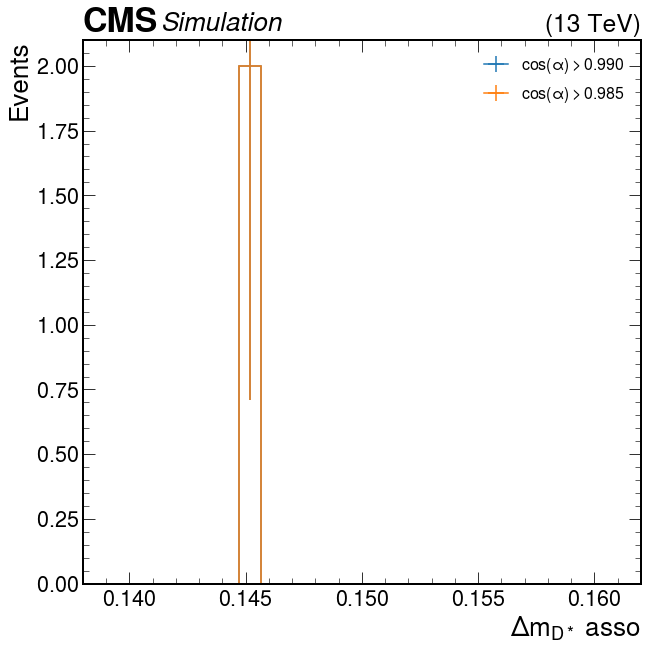

In [32]:
# Dstal deltam
#plot_comparison((output_phi1['asso_dstar_deltamr'], output_phi2['asso_dstar_deltamr'], output_phi3['asso_dstar_deltamr'], output_phi4['asso_dstar_deltamr']), legend=legend)
plot_comparison((output_phi1['asso_dstar_deltamr'], output_phi2['asso_dstar_deltamr'],), legend=legend)

In [ ]:
# JpsiDstar mass plot
plot_comparison((output_phi1['JpsiDstar_mass'], output_phi2['JpsiDstar_mass'], output_phi3['JpsiDstar_mass'], output_phi4['JpsiDstar_mass']), legend=legend)

In [ ]:
# JpsiDstar delta rapidity plot
plot_comparison((output_phi1['JpsiDstar_deltarap'], output_phi2['JpsiDstar_deltarap'], output_phi3['JpsiDstar_deltarap'], output_phi4['JpsiDstar_deltarap']), legend=legend)

#  D0 from D* $ p_T $

 ## $ p_T $ > 4.0 GeV

In [60]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=4.0
d0dl=3.0

output_pt1 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")


# Number of candidates
nevt = output_pt1['cutflow']['Number of events']
JpsiDstar = output_pt1['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_pt1['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Preprocessing:   0%|          | 0/240 [00:00<?, ?file/s]

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 201.69 s
There are 94 JpsiDstars in 44285 events
There are 75 events with JpsiDstars


## $ p_T $ > 3.0 GeV

In [61]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=3.0

output_pt2 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_pt2['cutflow']['Number of events']
JpsiDstar = output_pt2['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_pt2['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 145.80 s
There are 122 JpsiDstars in 44285 events
There are 98 events with JpsiDstars


 ## $ p_T $ > 2.0 GeV

In [62]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=2.0
d0dl=3.0

output_pt3 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_pt3['cutflow']['Number of events']
JpsiDstar = output_pt3['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_pt3['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 129.63 s
There are 123 JpsiDstars in 44285 events
There are 99 events with JpsiDstars


 ## $ p_T $ > 1.0 GeV

In [63]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=1.0
d0dl=3.0

output_pt4 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_pt4['cutflow']['Number of events']
JpsiDstar = output_pt4['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_pt4['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 127.82 s
There are 123 JpsiDstars in 44285 events
There are 99 events with JpsiDstars


 ### Legend

In [ ]:
#legend = [r"$ p_T > 4.0 GeV $", r"$ p_T > 3.0 GeV $", r"$ p_T > 2.0 GeV $", r"$ p_T > 1.0 GeV $"]
legend = [r"$ p_T > 4.0 GeV $", r"$ p_T > 3.0 GeV $"]

 ### Plots

In [ ]:
# Dstal deltamr
#data_list = (output1['asso_dstar_deltamr'], output2['asso_dstar_deltamr'], output3['asso_dstar_deltamr'], output4['asso_dstar_deltamr'])
data_list = (output1['asso_dstar_deltamr'], output2['asso_dstar_deltamr'])

plot_comparison(data_list, legend=legend)

#  D0 (from D*) decay length significance

## dl > 3.0

In [64]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=3.0

output_dl1 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_dl1['cutflow']['Number of events']
JpsiDstar = output_dl1['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_dl1['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 131.22 s
There are 122 JpsiDstars in 44285 events
There are 98 events with JpsiDstars


## dl > 2.9

In [65]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=2.9

output_dl2 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_dl2['cutflow']['Number of events']
JpsiDstar = output_dl2['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_dl2['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 131.05 s
There are 126 JpsiDstars in 44285 events
There are 102 events with JpsiDstars


## dl > 2.8

In [66]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=2.8

output_dl3 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_dl3['cutflow']['Number of events']
JpsiDstar = output_dl3['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_dl3['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 129.12 s
There are 129 JpsiDstars in 44285 events
There are 105 events with JpsiDstars


## dl > 2.7

In [67]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=2.7

output_dl4 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_dl4['cutflow']['Number of events']
JpsiDstar = output_dl4['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_dl4['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 126.46 s
There are 140 JpsiDstars in 44285 events
There are 111 events with JpsiDstars


## dl > 2.6

In [68]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=2.6

output_dl5 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_dl5['cutflow']['Number of events']
JpsiDstar = output_dl5['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_dl5['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 126.23 s
There are 144 JpsiDstars in 44285 events
There are 114 events with JpsiDstars


## dl > 2.5

In [69]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=2.5

output_dl6 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_dl6['cutflow']['Number of events']
JpsiDstar = output_dl6['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_dl6['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 126.44 s
There are 146 JpsiDstars in 44285 events
There are 116 events with JpsiDstars


## dl > 2.0

In [70]:
data = {"test": files[0:340]}
                      
tstart = time.time()

phicut=0.990
d0pt=3.0
d0dl=2.0

output_dl7 = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_dl7['cutflow']['Number of events']
JpsiDstar = output_dl7['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_dl7['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 126.80 s
There are 178 JpsiDstars in 44285 events
There are 140 events with JpsiDstars


## Legend

In [ ]:
#legend = [r"$ dl_{sig} > 3.0  $", r"$ dl_{sig} > 2.9  $", r"$ dl_{sig} > 2.8  $", r"$ dl_{sig} > 2.7  $",
#          r"$ dl_{sig} > 2.6  $", r"$ dl_{sig} > 2.5  $", r"$ dl_{sig} > 2.0  $"]
legend = [r"$ dl_{sig} > 3.0  $", r"$ dl_{sig} > 2.5  $", r"$ dl_{sig} > 2.0  $",]

## Plots

In [ ]:
# Dstal deltamr
#data_list = (output1['asso_dstar_deltamr'], output2['asso_dstar_deltamr'], output3['asso_dstar_deltamr'], output4['asso_dstar_deltamr'],
#             output5['asso_dstar_deltamr'], output6['asso_dstar_deltamr'], output7['asso_dstar_deltamr'])
data_list = (output1['asso_dstar_deltamr'], output6['asso_dstar_deltamr'], output7['asso_dstar_deltamr'])
ax = plot_comparison(data_list, legend=legend)
ax.set_ylim(0, 80)

#  Comparison old and new cuts

## old

 * D0 from D* $ cos(\phi) $ > 0.99
 * D0 from D* $ p_T $ > 3 GeV
 * D0 from D* decay length significance > 3

In [35]:
data = {"test": files[0:340]}
                      
tstart = time.time()

d0cosphi=0.99
d0pt=3.0
d0dl=3

output_old = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_old['cutflow']['Number of events']
JpsiDstar = output_old['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_old['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Preprocessing:   0%|          | 0/240 [00:00<?, ?file/s]

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 205.53 s
There are 55 JpsiDstars in 44285 events
There are 47 events with JpsiDstars


## new

 * D0 from D* $ cos(\phi) $ > 0.975
 * D0 from D* $ p_T $ > 3 GeV
 * D0 from D* decay length significance > 2

In [36]:
data = {"test": files[0:340]}
                      
tstart = time.time()

d0cosphi=0.975
d0pt=3.0
d0dl=2


output_new = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

# Number of candidates
nevt = output_new['cutflow']['Number of events']
JpsiDstar = output_new['cutflow']['Number of DimuDstar']
nevts_with_jpsidstar = output_new['cutflow']['Number of evts with DimuDstar']
print(f"There are {JpsiDstar} JpsiDstars in {nevt} events")
print(f"There are {nevts_with_jpsidstar} events with JpsiDstars")

Processing:   0%|          | 0/340 [00:00<?, ?chunk/s]

Process finished in: 129.50 s
There are 73 JpsiDstars in 44285 events
There are 62 events with JpsiDstars


## Legend

In [37]:
legend = ['old cuts', 'new cuts']

## Plots

/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


(0.0, 80.0)

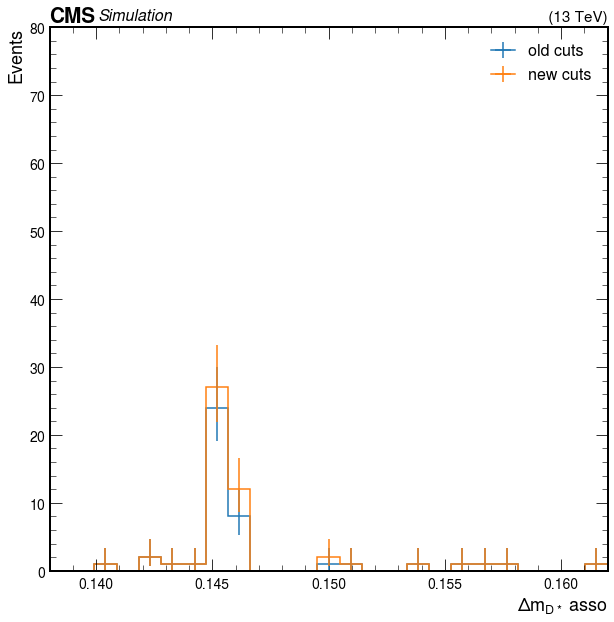

In [38]:
data_list = (output_old['asso_dstar_deltamr'], output_new['asso_dstar_deltamr'])
ax = plot_comparison(data_list, legend=legend)
ax.set_ylim(0, 80)

In [ ]:
output2['cutflow']['Number of DimuDstar']